In [121]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import graphviz

import os
import glob
from google.colab import drive
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


In [122]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the directory path
main_dir = "/content/drive/My Drive/Capstone_Organized_Data/NewerData_Final"

# Verify if the directory exists
print("Directory exists:", os.path.exists(main_dir))
!cd "/content/drive/My Drive/Capstone_Organized_Data" && ls

# List all CSV files in the directory
csv_files = [file for file in os.listdir(main_dir) if file.endswith(".csv")]

# Define the column names
column_names = ["reading", "voltage", "LED_temp", "photo_temp", "mode", "concentration"]

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over each CSV file
for file in csv_files:
    file_path = os.path.join(main_dir, file)

    # Read CSV while skipping the first row
    df = pd.read_csv(file_path, skiprows=1, header=None)  # Skip the header row

    # Assign new column names
    df.columns = column_names

    # Append to the list
    dataframes.append(df)

    reordered_dataframes = []

for dataframe in dataframes:
    subframes = []
    #df_mode_none = dataframe[dataframe['mode'] == 'none']
    df_mode_1550 = dataframe[dataframe['mode'] == '1550']
    df_mode_1200 = dataframe[dataframe['mode'] == '1200']
    df_mode_both = dataframe[dataframe['mode'] == 'both']
    #subframes.append(df_mode_none)
    subframes.append(df_mode_1550)
    subframes.append(df_mode_1200)
    subframes.append(df_mode_both)
    subframes_modeified=[]
    for sf in subframes:
        mode_value = sf['mode'].iloc[0]  # Get the 'mode' value of the first row
        # Set new column names
        new_column_names = [
            f"reading", f"voltage_{mode_value}", f"LED_temp_{mode_value}",
            f"photo_temp_{mode_value}","mode",  f"concentration"
        ]
        sf.columns = new_column_names
        if mode_value == "1550" or mode_value == "1200":
            sf = sf.drop(columns=["concentration"])
        sf = sf.reset_index(drop=True)
        sf = sf.drop(columns=["mode"])
        sf = sf.drop(columns=["reading"])
        subframes_modeified.append(sf)
    combined_df = pd.concat(subframes_modeified, axis=1)
    df.rename(columns={'concentration_both': 'concentration'}, inplace=True)
    reordered_dataframes.append(combined_df)

final_df_nonavg = pd.concat(reordered_dataframes, axis=0).reset_index(drop=True)
print(final_df_nonavg.shape)
final_df = final_df_nonavg.groupby(final_df_nonavg.index // 5).mean()


Mounted at /content/drive
Directory exists: True
 Capstone_Data_Collection.xlsx		  FNN_model_all_features.ipynb	 ReferenceData_Final
 Capstone_ML.ipynb			  IRLData_Final			 sample2025_03_21_1209.csv
'Copy of Capstone_ML.ipynb'		  NewData			 sample2025_03_21_1212.csv
'Copy of FNN_model_voltages_only.ipynb'   NewerData_Final		 sample2025_03_21_1213.csv
 EvenNewer				  RawData
(650, 10)


In [123]:
print(final_df)
print(final_df.shape)
# Printing a scatter plot
# sb.pairplot(final_df, hue=('concentration'))
# plt.show()

     voltage_1550  LED_temp_1550  photo_temp_1550  voltage_1200  \
0        0.530857       24.14151         24.00171      1.119168   
1        0.602901       24.14151         24.00171      1.084802   
2        0.654310       24.14151         24.00171      0.978216   
3        0.645384       24.14151         24.00171      1.078278   
4        0.572910       24.14151         24.00171      1.009749   
..            ...            ...              ...           ...   
125      1.138285       22.60165         22.60165      1.303335   
126      1.139903       22.60165         22.60165      1.307078   
127      1.136389       22.60165         22.60165      1.304094   
128      1.138563       22.60165         22.60165      1.306648   
129      1.137450       22.60165         22.60165      1.304271   

     LED_temp_1200  photo_temp_1200  voltage_both  LED_temp_both  \
0         24.00171         24.00171      1.607669       23.93179   
1         24.00171         24.00171      1.658269       23.

In [124]:
_# Extract features (X) and target (y)
X = final_df[['voltage_1550', 'voltage_1200', 'voltage_both']]
y = final_df['concentration']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Define the FNN model with Batch Normalization
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)  # Batch Normalization
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply BatchNorm after FC layer
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)  # Apply BatchNorm after FC layer
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the model, optimizer, and loss function
model = FNN(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Early stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val.unsqueeze(1))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break

# Test evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test.unsqueeze(1))
    print(f"Test Loss: {test_loss.item():.4f}")

    # Calculate R-squared
    r2 = r2_score(y_test.numpy(), y_pred.numpy())
    print(f"R-squared: {r2:.4f}")

Epoch [1/100], Loss: 1390.1270, Validation Loss: 2643.6770
Epoch [2/100], Loss: 164.7346, Validation Loss: 2581.9475
Epoch [3/100], Loss: 3140.0354, Validation Loss: 2501.3457
Epoch [4/100], Loss: 3578.0071, Validation Loss: 2456.8220
Epoch [5/100], Loss: 4875.2012, Validation Loss: 2365.3047
Epoch [6/100], Loss: 14.2842, Validation Loss: 2328.0635
Epoch [7/100], Loss: 1811.0808, Validation Loss: 2206.0933
Epoch [8/100], Loss: 4952.5664, Validation Loss: 2066.7644
Epoch [9/100], Loss: 146.9078, Validation Loss: 1833.0996
Epoch [10/100], Loss: 2396.3149, Validation Loss: 1954.5278
Epoch [11/100], Loss: 2404.0391, Validation Loss: 1760.2708
Epoch [12/100], Loss: 2588.9832, Validation Loss: 1783.8033
Epoch [13/100], Loss: 280.3701, Validation Loss: 1688.0859
Epoch [14/100], Loss: 2060.3442, Validation Loss: 1656.0930
Epoch [15/100], Loss: 132.2388, Validation Loss: 1494.8516
Epoch [16/100], Loss: 468.3777, Validation Loss: 1324.9485
Epoch [17/100], Loss: 90.6192, Validation Loss: 1099.654

    Prediction  Expectation
0    25.536680         40.0
1    43.499107         40.0
2    30.093081         10.0
3    11.589580          0.0
4    54.921654         50.0
5    60.718590         50.0
6     4.034321          0.0
7    21.847006         20.0
8    35.668930         30.0
9    22.309107         10.0
10   22.094170         30.0
11   56.245949        100.0
12   74.088783        100.0


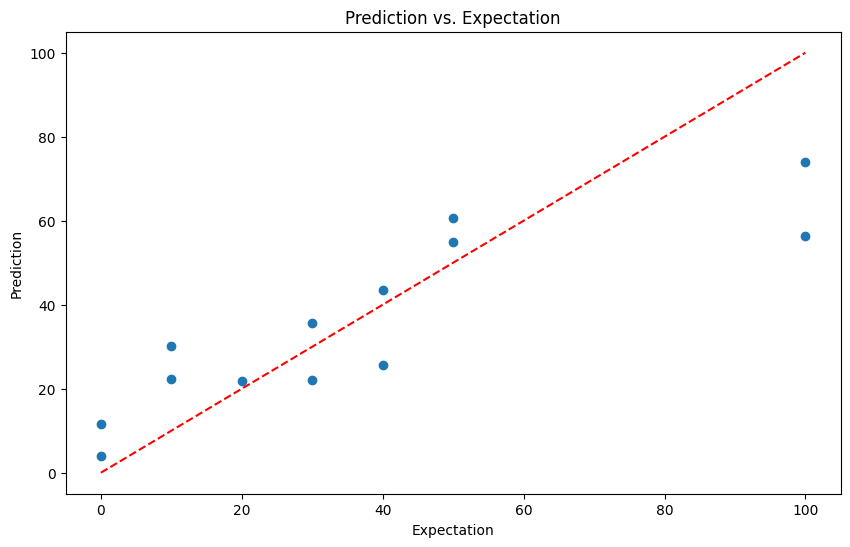

In [125]:

# Assuming y_pred and y_test are your predicted and actual values as PyTorch tensors
# Convert them to NumPy arrays for easier manipulation
y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test.numpy()

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Prediction': y_pred_np, 'Expectation': y_test_np})

# Print the DataFrame
print(results_df)

# You can also plot the predictions vs. expectations
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_np)
plt.xlabel('Expectation')
plt.ylabel('Prediction')
plt.title('Prediction vs. Expectation')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Add a diagonal line for reference
plt.show()


In [126]:
test_dir = "/content/drive/My Drive/Capstone_Organized_Data/"
# List all CSV files in the directory
csv_test_files = [file for file in os.listdir(test_dir) if file.endswith(".csv")]

# Define the column names
column_names = ["reading", "voltage", "LED_temp", "photo_temp", "mode", "concentration"]

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over each CSV file
for file in csv_test_files:
    file_path = os.path.join(test_dir, file)

    # Read CSV while skipping the first row
    df = pd.read_csv(file_path, skiprows=1, header=None)  # Skip the header row

    # Assign new column names
    df.columns = column_names

    # Append to the list
    dataframes.append(df)

    reordered_dataframes = []

for dataframe in dataframes:
    subframes = []
    #df_mode_none = dataframe[dataframe['mode'] == 'none']
    df_mode_1550 = dataframe[dataframe['mode'] == '1550']
    df_mode_1200 = dataframe[dataframe['mode'] == '1200']
    df_mode_both = dataframe[dataframe['mode'] == 'both']
    #subframes.append(df_mode_none)
    subframes.append(df_mode_1550)
    subframes.append(df_mode_1200)
    subframes.append(df_mode_both)
    subframes_modeified=[]
    for sf in subframes:
        mode_value = sf['mode'].iloc[0]  # Get the 'mode' value of the first row
        # Set new column names
        new_column_names = [
            f"reading", f"voltage_{mode_value}", f"LED_temp_{mode_value}",
            f"photo_temp_{mode_value}","mode",  f"concentration"
        ]
        sf.columns = new_column_names
        if mode_value == "1550" or mode_value == "1200":
            sf = sf.drop(columns=["concentration"])
        sf = sf.reset_index(drop=True)
        sf = sf.drop(columns=["mode"])
        sf = sf.drop(columns=["reading"])
        subframes_modeified.append(sf)
    combined_df = pd.concat(subframes_modeified, axis=1)
    df.rename(columns={'concentration_both': 'concentration'}, inplace=True)
    reordered_dataframes.append(combined_df)

inf_test_df = pd.concat(reordered_dataframes, axis=0)
print(inf_test_df.shape)
print(inf_test_df)

(150, 10)
    voltage_1550  LED_temp_1550  photo_temp_1550  voltage_1200  LED_temp_1200  \
0       0.757356       32.55673         25.95761      0.811851       36.28387   
1       0.757356       32.55673         25.95761      0.811851       36.28387   
2       0.757356       32.55673         25.95761      0.811851       36.28387   
3       0.754827       32.55673         25.95761      0.811471       36.28387   
4       0.754827       32.55673         25.95761      0.811471       36.28387   
..           ...            ...              ...           ...            ...   
45      0.746483       28.33347         25.39899      0.686299       30.29715   
46      0.746483       28.33347         25.39899      0.686299       30.29715   
47      0.745345       28.33347         25.39899      0.686299       30.29715   
48      0.745345       28.33347         25.39899      0.678965       30.29715   
49      0.740919       28.33347         25.39899      0.678965       30.29715   

    photo_temp_12

     Prediction  Expectation
0     67.419350         20.0
1     67.419350         20.0
2     67.419350         20.0
3     66.727371         20.0
4     66.727371         20.0
..          ...          ...
145   90.871857         50.0
146   90.871857         50.0
147   90.558235         50.0
148   91.869209         50.0
149   91.223923         50.0

[150 rows x 2 columns]


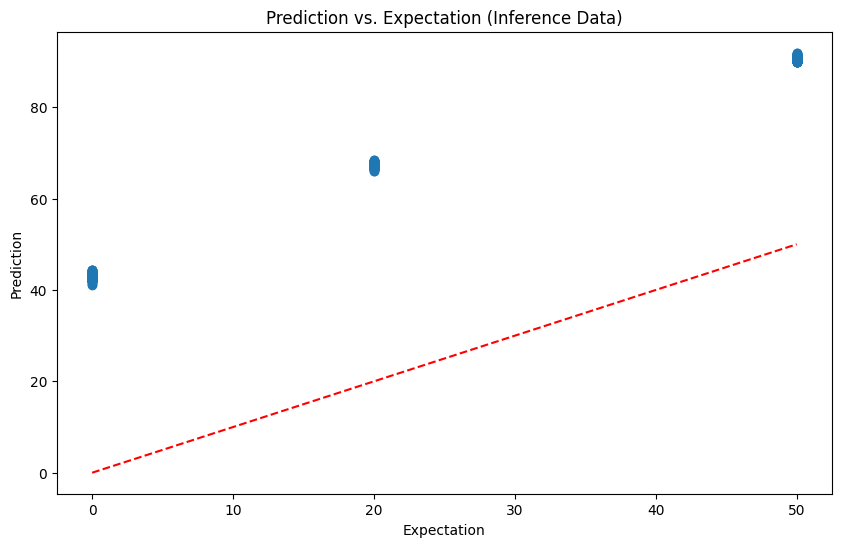

In [127]:
# prompt: write the code to run prediction on inf_test using the model and show predicted vs expected values

# Assuming inf_test_df is your DataFrame for inference
X_inf_test = inf_test_df[['voltage_1550', 'voltage_1200', 'voltage_both']]
y_inf_test = inf_test_df['concentration']

# Standardize features using the same scaler used for training
X_inf_test = scaler.transform(X_inf_test)

# Convert data to PyTorch tensors
X_inf_test = torch.tensor(X_inf_test, dtype=torch.float32)
y_inf_test = torch.tensor(y_inf_test.values, dtype=torch.float32)

# Make predictions using the trained model
model.eval()
with torch.no_grad():
    y_inf_pred = model(X_inf_test)

# Convert predictions to NumPy arrays
y_inf_pred_np = y_inf_pred.numpy().flatten()
y_inf_test_np = y_inf_test.numpy()

# Create a DataFrame to store the results
inf_results_df = pd.DataFrame({'Prediction': y_inf_pred_np, 'Expectation': y_inf_test_np})

# Print the DataFrame
print(inf_results_df)

# You can also plot the predictions vs. expectations for the inference data
plt.figure(figsize=(10, 6))
plt.scatter(y_inf_test_np, y_inf_pred_np)
plt.xlabel('Expectation')
plt.ylabel('Prediction')
plt.title('Prediction vs. Expectation (Inference Data)')
plt.plot([min(y_inf_test_np), max(y_inf_test_np)], [min(y_inf_test_np), max(y_inf_test_np)], color='red', linestyle='--')
plt.show()
